Using OCP to enumerate adsorbates on catalyst surfaces
======================================================

In [15]:
from ocpmodels.common.relaxation.ase_utils import OCPCalculator
import ase.io
from ase.optimize import BFGS
import sys
from scipy.stats import linregress
import pickle
import matplotlib.pyplot as plt

from ocdata.core import Adsorbate, AdsorbateSlabConfig, Bulk, Slab
import os
from glob import glob
import pandas as pd
from ocdata.utils import DetectTrajAnomaly

# Optional - see below
import numpy as np

# Introduction

Hello All! We are so glad you could join us to learn a bit more about using OCP models to accelerate chemical simulations. We will reproduce Fig 6b from the following paper: Zhou, Jing, et al. "Enhanced Catalytic Activity of Bimetallic Ordered Catalysts for Nitrogen Reduction Reaction by Perturbation of Scaling Relations." ACS Catalysis 13.4 (2023): 2190-2201.

To do this, we will enumerate adsorbate-slab configurations and run ML relaxations on them to find the lowest energy configuration. We will assess parity between the model predicted values and those reported in the paper. Finally we will make the figure and assess separability of the NRR favored and HER favored domains.

# Enumerate the adsorbate-slab configurations to run relaxations on

Be sure to set the path in `ocdata/configs/paths.py` to point to the correct place or pass the paths as an argument. The database pickles can be found in `ocdata/databases/pkls`. We will show one explicitly here as an example and then run all of them in an automated fashion for brevity.

In [3]:
bulk_src_id = "oqmd-343039"
adsorbate_smiles_nnh = "*N*NH"
adsorbate_smiles_h = "*H"

bulk = Bulk(bulk_src_id_from_db = bulk_src_id, bulk_db_path = "NRR_example_bulks.pkl")
adsorbate_H = Adsorbate(adsorbate_smiles_from_db = adsorbate_smiles_h, adsorbate_db_path = "/private/home/brookwander/Open-Catalyst-Dataset/ocdata/databases/pkls/adsorbates.pkl")
adsorbate_NNH = Adsorbate(adsorbate_smiles_from_db = adsorbate_smiles_nnh, adsorbate_db_path = "/private/home/brookwander/Open-Catalyst-Dataset/ocdata/databases/pkls/adsorbates.pkl")
slab = Slab.from_bulk_get_specific_millers(bulk= bulk, specific_millers = (1,1,1))

In [5]:
# Perform heuristic placements
heuristic_adslabs = AdsorbateSlabConfig(slab[0], adsorbate_H, mode="heuristic")

# Perform random placements
# (for AdsorbML we use `num_sites = 100` but we will use 4 for brevity here)
random_adslabs = AdsorbateSlabConfig(slab[0], adsorbate_H, mode="random_site_heuristic_placement", num_sites = 20)

adslabs = [*heuristic_adslabs.atoms_list, *random_adslabs.atoms_list]

# Run ML relaxations:

There are 2 options for how to do this.
 1. Using `OCPCalculator` as the calculator within the ASE framework
 2. By writing objects to lmdb and relaxing them using `main.py` in the ocp repo
 
(1) is really only adequate for small stuff and it is what I will show here, but if you plan to run many relaxations, you should definitely use (2). More details about writing lmdbs has been provided [here](https://github.com/Open-Catalyst-Project/ocp/blob/main/tutorials/lmdb_dataset_creation.ipynb) - follow the IS2RS/IS2RE instructions. And more information about running relaxations once the lmdb has been written is [here](https://github.com/Open-Catalyst-Project/ocp/blob/main/TRAIN.md#initial-structure-to-relaxed-structure-is2rs).

You need to provide the calculator with a path to a model checkpoint file. That can be downloaded [here](https://github.com/Open-Catalyst-Project/ocp/blob/main/MODELS.md)


Running the model with BFGS prints at each relaxation step is a lot to print. So we will just run one to demonstrate

In [9]:
checkpoint_path = "/private/home/brookwander/ocp_checkpoints/escn_l6_m3_lay20_all_md_s2ef.pt"
os.makedirs(f"data/{bulk_src_id}_{adsorbate_smiles_h}", exist_ok=True)

# Define the calculator
calc = OCPCalculator(checkpoint=checkpoint_path, cpu=False)

os.mkdir(f"data/{bulk_src_id}_H")
adslab = adslabs[0]
adslab.calc = calc
opt = BFGS(adslab, trajectory=f"data/{bulk_src_id}_H/test.traj")
opt.run(fmax=0.05, steps=100)

amp: false
cmd:
  checkpoint_dir: /private/home/brookwander/random/nrr/checkpoints/2023-07-07-09-59-44
  commit: 819e11d
  identifier: ''
  logs_dir: /private/home/brookwander/random/nrr/logs/tensorboard/2023-07-07-09-59-44
  print_every: 100
  results_dir: /private/home/brookwander/random/nrr/results/2023-07-07-09-59-44
  seed: null
  timestamp_id: 2023-07-07-09-59-44
dataset: null
gpus: 1
logger: tensorboard
model: escn
model_attributes:
  basis_width_scalar: 2.0
  cutoff: 12.0
  distance_function: gaussian
  hidden_channels: 384
  lmax_list:
  - 6
  max_neighbors: 20
  mmax_list:
  - 3
  num_layers: 20
  num_sphere_samples: 128
  otf_graph: true
  regress_forces: true
  sphere_channels: 160
  use_pbc: true
noddp: false
optim:
  batch_size: 3
  clip_grad_norm: 20
  ema_decay: 0.999
  energy_coefficient: 4
  eval_batch_size: 3
  eval_every: 5000
  force_coefficient: 100
  loss_energy: mae
  loss_force: l2mae
  lr_gamma: 0.3
  lr_initial: 0.0008
  lr_milestones:
  - 433166
  - 541460
 

True

Now we will run everything but silence the BFGS print outs

In [10]:
## THIS WILL TAKE ~1h for all 19 bulks which feels too long!
with open("NRR_example_bulks.pkl", "rb") as f:
    bulks = pickle.load(f)
bulk_ids = pd.DataFrame(bulks).src_id.tolist()

for bulk_src_id in bulk_ids: 
    # Enumerate slabs and establish adsorbates
    bulk = Bulk(bulk_src_id_from_db = bulk_src_id, bulk_db_path = "NRR_example_bulks.pkl")
    slab = Slab.from_bulk_get_specific_millers(bulk= bulk, specific_millers = (1,1,1))

    # Perform heuristic placements
    heuristic_adslabs_H = AdsorbateSlabConfig(slab[0], adsorbate_H, mode="heuristic")
    heuristic_adslabs_NNH = AdsorbateSlabConfig(slab[0], adsorbate_NNH, mode="heuristic")

    #Run relaxations
    os.makedirs(f"data/{bulk_src_id}_H", exist_ok=True)
    os.makedirs(f"data/{bulk_src_id}_NNH", exist_ok=True)
    old_stdout = sys.stdout # backup current stdout
    sys.stdout = open(os.devnull, "w")
    # Set up the calculator
    for idx, adslab in enumerate(heuristic_adslabs_H.atoms_list):
        adslab.calc = calc
        opt = BFGS(adslab, trajectory=f"data/{bulk_src_id}_H/{idx}.traj")
        opt.run(fmax=0.05, steps=100)
        
    for idx, adslab in enumerate(heuristic_adslabs_NNH.atoms_list):
        adslab.calc = calc
        opt = BFGS(adslab, trajectory=f"data/{bulk_src_id}_NNH/{idx}.traj")
        opt.run(fmax=0.05, steps=100)
    sys.stdout = old_stdout

# Parse the trajectories and post-process

As a post-processing step we check to see if:
1. the adsorbate desorbed
2. the adsorbate disassociated
3. the adsorbate intercalated
4. the surface has changed

We check these because the effect our referencing scheme and may result in erroneous energies. For (4), the relaxed surface should really be supplied as well. It will be necessary when correcting the SP / RX energies later. Since we don't have it here, we will ommit supplying it, and the detector will instead compare the initial and final slab from the adsorbate-slab relaxation trajectory. If a relaxed slab is provided, the detector will compare it and the slab after the adsorbate-slab relaxation. The latter is more correct!

In [12]:
# Iterate over trajs to extract results
min_E = []
for file_outer in glob("data/*"):
    ads = file_outer.split("_")[1]
    bulk = file_outer.split("/")[1].split("_")[0]
    results = []
    for file in glob(f"{file_outer}/*.traj"):
        rx_id = file.split("/")[-1].split(".")[0]
        traj = ase.io.read(file, ":")

        # Check to see if the trajectory is anomolous
        detector = DetectTrajAnomaly(traj[0], traj[-1], traj[0].get_tags())
        anom = (
            detector.is_adsorbate_dissociated()
            or detector.is_adsorbate_desorbed()
            or detector.has_surface_changed()
            or detector.is_adsorbate_intercalated()
        )
        rx_energy = traj[-1].get_potential_energy()
        results.append({"relaxation_idx": rx_id, "relaxed_atoms": traj[-1],
                        "relaxed_energy_ml": rx_energy, "anomolous": anom})
    df = pd.DataFrame(results)

    df = df[~df.anomolous].copy().reset_index()
    min_e = min(df.relaxed_energy_ml.tolist())
    min_E.append({"adsorbate":ads, "bulk_id":bulk, "min_E_ml": min_e})

df = pd.DataFrame(min_E)
df_h = df[df.adsorbate == "H"]
df_nnh = df[df.adsorbate == "NNH"]
df_flat = df_h.merge(df_nnh, on = "bulk_id")

# Make parity plots for values obtained by ML v. reported in the paper

In [31]:
# Add literature data to the dataframe
with open("literature_data.pkl", "rb") as f:
    literature_data = pickle.load(f)
df_all = df_flat.merge(pd.DataFrame(literature_data), on = "bulk_id")

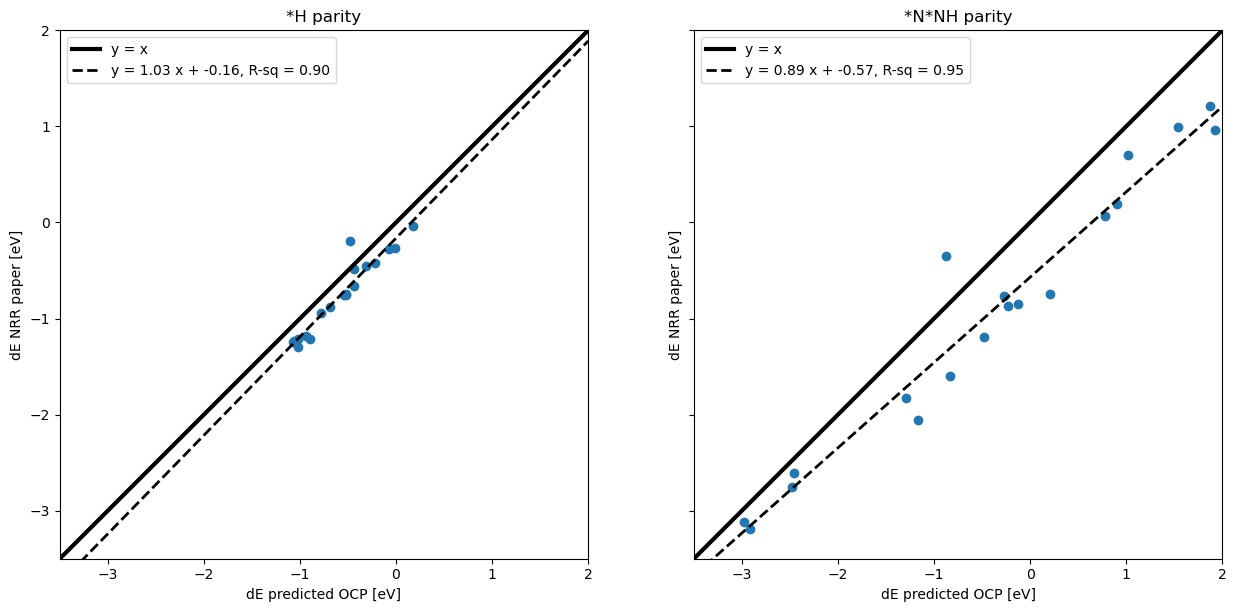

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(15)
x = df_all.min_E_ml_x.tolist()
y = df_all.E_lit_H.tolist()
ax1.set_title("*H parity")
ax1.plot([-3.5, 2], [-3.5, 2], "k-", linewidth=3)
slope, intercept, r, p, se = linregress(x, y)
ax1.plot(
    [-3.5, 2],
    [
        -3.5 * slope + intercept,
        2 * slope + intercept,
    ],
    "k--",
    linewidth=2,
)

ax1.legend(
    [
        "y = x",
        f"y = {slope:1.2f} x + {intercept:1.2f}, R-sq = {r**2:1.2f}",
    ],
    loc="upper left",
)
ax1.scatter(x, y)
ax1.axis("square")
ax1.set_xlim([-3.5, 2])
ax1.set_ylim([-3.5, 2])
ax1.set_xlabel("dE predicted OCP [eV]")
ax1.set_ylabel("dE NRR paper [eV]");


x = df_all.min_E_ml_y.tolist()
y = df_all.E_lit_NNH.tolist()
ax2.set_title("*N*NH parity")
ax2.plot([-3.5, 2], [-3.5, 2], "k-", linewidth=3)
slope, intercept, r, p, se = linregress(x, y)
ax2.plot(
    [-3.5, 2],
    [
        -3.5 * slope + intercept,
        2 * slope + intercept,
    ],
    "k--",
    linewidth=2,
)

ax2.legend(
    [
        "y = x",
        f"y = {slope:1.2f} x + {intercept:1.2f}, R-sq = {r**2:1.2f}",
    ],
    loc="upper left",
)
ax2.scatter(x, y)
ax2.axis("square")
ax2.set_xlim([-3.5, 2])
ax2.set_ylim([-3.5, 2])
ax2.set_xlabel("dE predicted OCP [eV]")
ax2.set_ylabel("dE NRR paper [eV]");
f.set_figwidth(15)
f.set_figheight(7)
f.savefig("parity.png")

# Make figure 6b and compare to literature results

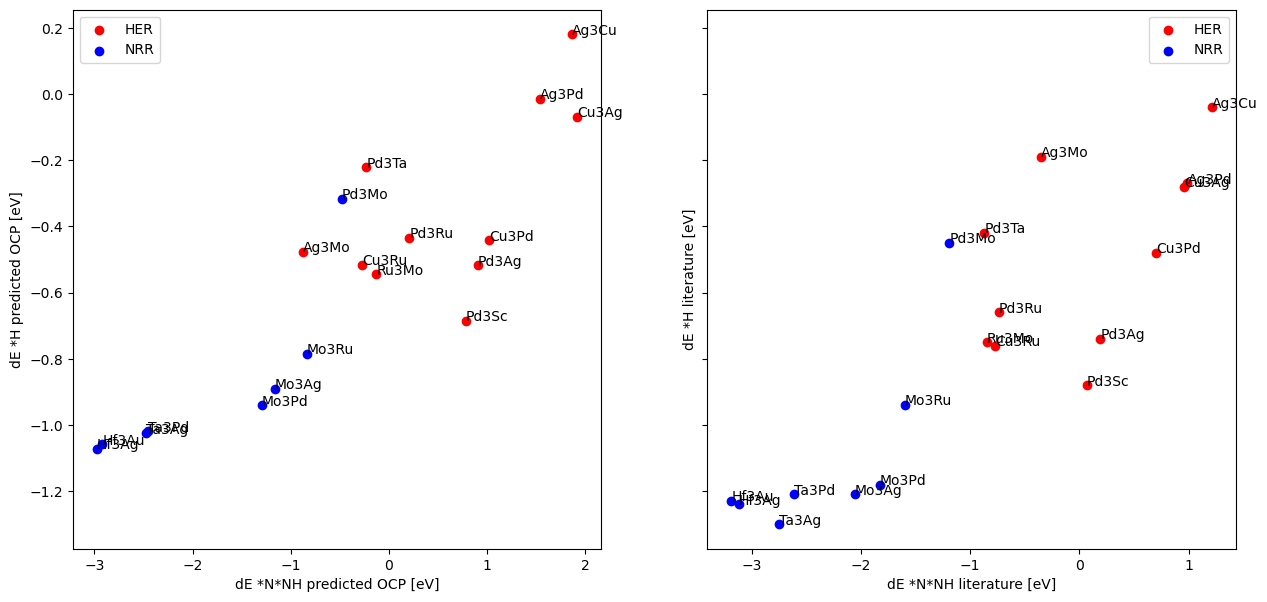

In [34]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
x = df_all[df_all.reaction == "HER"].min_E_ml_y.tolist()
y = df_all[df_all.reaction == "HER"].min_E_ml_x.tolist()
comp = df_all[df_all.reaction == "HER"].composition.tolist()

ax1.scatter(x, y,c= "r", label = "HER")
for i, txt in enumerate(comp):
    ax1.annotate(txt, (x[i], y[i]))

x = df_all[df_all.reaction == "NRR"].min_E_ml_y.tolist()
y = df_all[df_all.reaction == "NRR"].min_E_ml_x.tolist()
comp = df_all[df_all.reaction == "NRR"].composition.tolist()
ax1.scatter(x, y,c= "b", label = "NRR")
for i, txt in enumerate(comp):
    ax1.annotate(txt, (x[i], y[i]))


ax1.legend()
ax1.set_xlabel("dE *N*NH predicted OCP [eV]")
ax1.set_ylabel("dE *H predicted OCP [eV]")


x = df_all[df_all.reaction == "HER"].E_lit_NNH.tolist()
y = df_all[df_all.reaction == "HER"].E_lit_H.tolist()
comp = df_all[df_all.reaction == "HER"].composition.tolist()

ax2.scatter(x, y,c= "r", label = "HER")
for i, txt in enumerate(comp):
    ax2.annotate(txt, (x[i], y[i]))

x = df_all[df_all.reaction == "NRR"].E_lit_NNH.tolist()
y = df_all[df_all.reaction == "NRR"].E_lit_H.tolist()
comp = df_all[df_all.reaction == "NRR"].composition.tolist()
ax2.scatter(x, y,c= "b", label = "NRR")
for i, txt in enumerate(comp):
    ax2.annotate(txt, (x[i], y[i]))

ax2.legend()
ax2.set_xlabel("dE *N*NH literature [eV]")
ax2.set_ylabel("dE *H literature [eV]")
f.set_figwidth(15)
f.set_figheight(7)
f.savefig("fig_6b.png")